In [1]:
import os
import shutil
import unittest
from catvae.trainer import LightningCatVAE, LightningLinearVAE
from catvae.sim import multinomial_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import argparse
import seaborn as sns

In [2]:
import torch
torch.__version__

'1.7.0.dev20200909'

# Simulate data

In [3]:
np.random.seed(0)
k = 10
sims = multinomial_bioms(k=k, D=50, N=1000, M=50000)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')

In [4]:
sims['tree']

<TreeNode, name: y0, internal node count: 48, tips count: 50>

In [5]:
sims['tree'].write('basis.nwk')

'basis.nwk'

# Train model

In [6]:
from pytorch_lightning.profiler import AdvancedProfiler

output_dir = 'output'
args = [
    '--train-biom', 'train.biom',
    '--test-biom', 'test.biom',
    '--val-biom', 'valid.biom',
    '--basis', 'basis.nwk',
    '--output-directory', output_dir,
    '--epochs', '100',
    '--batch-size', '50',
    '--num-workers', '10',
    '--scheduler', 'cosine',
    '--use-analytic-elbo', 'False',
    '--learning-rate', '1e-1',
    '--n-latent', str(k),
    '--gpus', '1'
]
parser = argparse.ArgumentParser(add_help=False)
#parser = LightningCatVAE.add_model_specific_args(parser)
parser = LightningLinearVAE.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)
model = LightningLinearVAE(args)
model.set_eigs(sims['eigvectors'], sims['eigs'])
profiler = AdvancedProfiler()

trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=10,
    #profiler=profiler,
    fast_dev_run=False,
    # auto_scale_batch_size='power'
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type      | Params
------------------------------------
0 | model | LinearVAE | 991   


Exception in thread Thread-101:
Traceback (most recent call last):
  File "/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_conne

1

In [12]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 12301), started 0:46:44 ago. (Use '!kill 12301' to kill it.)

In [9]:
trainer.model

LightningLinearVAE(
  (model): LinearVAE(
    (encoder): Linear(in_features=49, out_features=10, bias=False)
    (decoder): ParametrizedLinear(
      in_features=10, out_features=49, bias=False
      (parametrizations): ModuleDict(
        (weight): GrassmannianTall(n=49, k=10, triv=expm)
      )
    )
  )
)

# Evaluate the model

In [14]:
!ls lightning_logs/version_9/checkpoints

ls: cannot access 'lightning_logs/version_9/checkpoints': No such file or directory


(0.8989694239297487, 0.0)


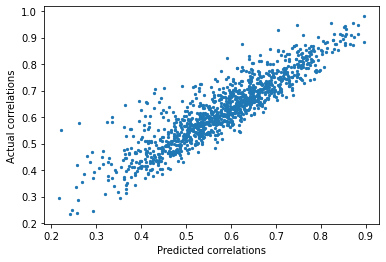

In [15]:
#W = model.model.get_loadings()
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

W = model.model.decoder.weight.detach().cpu().numpy()

d_estW = pdist(W)
simW = sims['W'] / np.sqrt(sims['eigs'])
dW = pdist(simW)

plt.scatter(dW, d_estW, s=5)
#plt.plot(np.linspace(0, 4), np.linspace(0, 4), 'r')
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))

In [16]:
model

LightningLinearVAE(
  (model): LinearVAE(
    (encoder): Linear(in_features=49, out_features=10, bias=False)
    (decoder): ParametrizedLinear(
      in_features=10, out_features=49, bias=False
      (parametrizations): ModuleDict(
        (weight): GrassmannianTall(n=49, k=10, triv=expm)
      )
    )
  )
)